## Workflow
- Get data ready (download from Kaggle, store, import).
- Prepare the data (preprocessing, the 3 sets, X & y).
- Choose and fit/train a model (TensorFlow Hub, tf.keras.applications, TensorBoard, EarlyStopping).
- Evaluating a model (making predictions, comparing them with the ground truth labels).
- Improve the model through experimentation (start with 1000 images, make sure it works, increase the number of images).
- Save, sharing and reloading your model.

In [1]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

import tensorflow as tf
import tensorflow_hub as hub
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
from matplotlib.pyplot import imread

Let's start with `labels.csv` which contains all of the image ID's and their assosciated dog breed (our data and labels).

In [2]:
labels_csv = pd.read_csv("data/labels.csv")
labels_csv.describe()

,id,breed
count,10222,10222
unique,10222,120
top,000bec180eb18c7604dcecc8fe0dba07,scottish_deerhound
freq,1,126


In [3]:
labels_csv.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


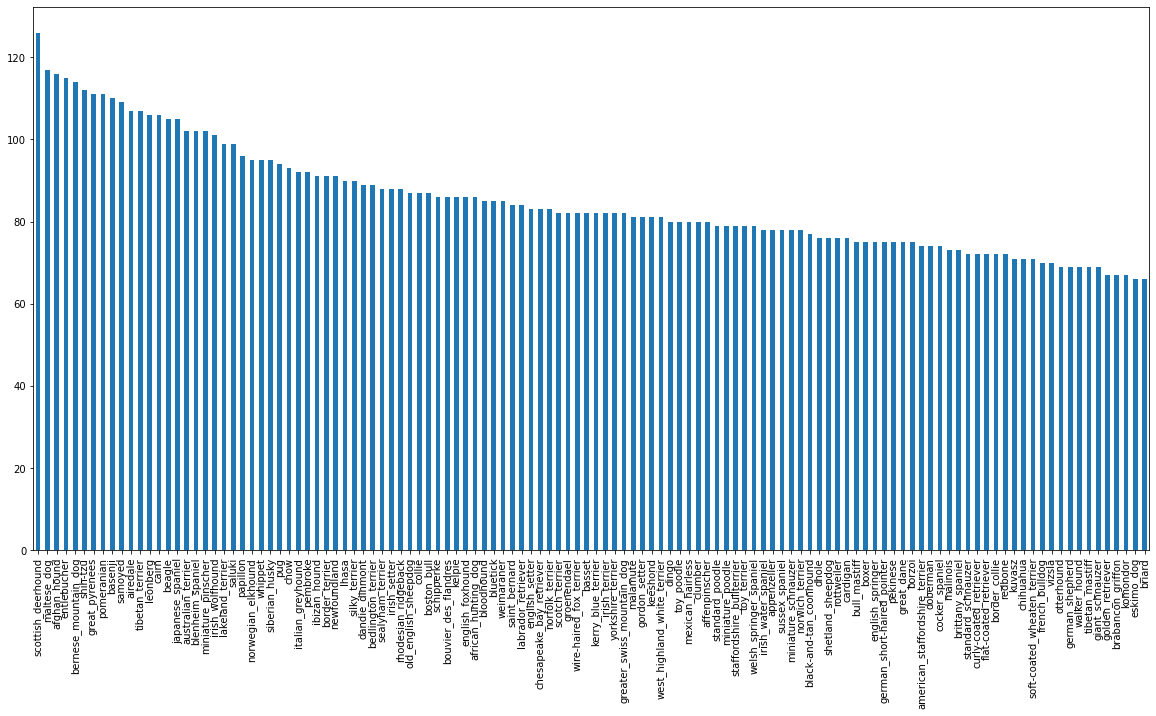

In [4]:
# How many images are there of each breed?
labels_csv["breed"].value_counts().plot.bar(figsize=(20, 10));

#### Getting images and their labels
Since we've got the image ID's and their labels in a DataFrame (`labels_csv`), we'll use it to create:

- A list a filepaths to training images
- An array of all labels
- An array of all unique labels

In [5]:
# Create pathnames from image ID's
filenames = ["data/train/" + fname + ".jpg" for fname in labels_csv["id"]]

# Check the first 10 filenames
filenames[:10]

['data/train/000bec180eb18c7604dcecc8fe0dba07.jpg',
 'data/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg',
 'data/train/001cdf01b096e06d78e9e5112d419397.jpg',
 'data/train/00214f311d5d2247d5dfe4fe24b2303d.jpg',
 'data/train/0021f9ceb3235effd7fcde7f7538ed62.jpg',
 'data/train/002211c81b498ef88e1b40b9abf84e1d.jpg',
 'data/train/00290d3e1fdd27226ba27a8ce248ce85.jpg',
 'data/train/002a283a315af96eaea0e28e7163b21b.jpg',
 'data/train/003df8b8a8b05244b1d920bb6cf451f9.jpg',
 'data/train/0042188c895a2f14ef64a918ed9c7b64.jpg']

In [6]:
# convert labels column to NumPy array
labels = labels_csv["breed"].to_numpy()
labels[:10]

array(['boston_bull', 'dingo', 'pekinese', 'bluetick', 'golden_retriever',
       'bedlington_terrier', 'bedlington_terrier', 'borzoi', 'basenji',
       'scottish_deerhound'], dtype=object)

In [7]:
# See if number of labels matches the number of filenames
if len(labels) == len(filenames):
    print("Number of labels matches number of filenames!")
else:
    print("Number of labels does not match number of filenames, check data directories.")

Number of labels matches number of filenames!


In [8]:
# The length of unique_breeds should be 120, meaning we're working with images of 120 different breeds of dogs.
# Now use unique_breeds to help turn our labels array into an array of booleans.

# Find the unique label values
unique_breeds = np.unique(labels)
len(unique_breeds)

120

#### Creating our own validation set
Since the dataset from Kaggle doesn't come with a validation set (a split of the data we can test our model on before making final predicitons on the test set), let's make one.

We could use [Scikit-Learn's train_test_split function](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) or we could simply make manual splits of the data.

For accessibility later, let's save our filenames variable to X (data) and our labels to y.

Since we're working with 10,000+ images, it's a good idea to work with a portion of them to make sure things are working before training on them all.

This is because computing with 10,000+ images could take a fairly long time. And our goal when working through machine learning projects is to reduce the time between experiments.

Let's start experimenting with 1000 and increase it as we need.

In [9]:
# Turn every label into a boolean array
boolean_labels = [label == np.array(unique_breeds) for label in labels]

# Setup X & y variables
X = filenames
y = boolean_labels

# Set number of images to use for experimenting
NUM_IMAGES = 1000
NUM_IMAGES

1000

In [10]:
# Import train_test_split from Scikit-Learn
from sklearn.model_selection import train_test_split

# Split them into training and validation using NUM_IMAGES 
X_train, X_val, y_train, y_val = train_test_split(X[:NUM_IMAGES],
                                                  y[:NUM_IMAGES], 
                                                  test_size=0.2,
                                                  random_state=42)

len(X_train), len(y_train), len(X_val), len(y_val)

(800, 800, 200, 200)

#### Preprocessing images (turning images into Tensors)
Our labels are in numeric format but our images are still just file paths.

Since we're using TensorFlow, our data has to be in the form of Tensors.

>*A Tensor is a way to represent information in numbers. If you're familar with NumPy arrays (you should be), a Tensor can be thought of as a combination of NumPy arrays, except with the special ability to be used on a GPU.*

Because of how TensorFlow stores information (in Tensors), it allows machine learning and deep learning models to be run on GPUs (generally faster at numerical computing).

To preprocess our images into Tensors we're going to write a function which does a few things:

- Takes an image filename as input.
- Uses TensorFlow to read the file and save it to a variable, image.
- Turn our image (a jpeg file) into Tensors.
- Resize the image to be of shape (224, 224).
- Return the modified image.

In [11]:
# Convert image to NumPy array
image = imread(filenames[7]) # read in an image
image.shape

(227, 231, 3)

**Notice the shape of image. It's (257, 231, 3). This is height, width, colour channel value.**

In [12]:
# Define image size
IMG_SIZE = 224

def process_image(image_path):
    """
    Takes an image file path and turns it into a Tensor.
    """
    # Read in image file
    image = tf.io.read_file(image_path)
    # Turn the jpeg image into numerical Tensor with 3 colour channels (Red, Green, Blue)
    image = tf.image.decode_jpeg(image, channels=3)
    # Convert the colour channel values from 0-225 values to 0-1 values
    image = tf.image.convert_image_dtype(image, tf.float32)
    # Resize the image to our desired size (224, 244)
    image = tf.image.resize(image, size=[IMG_SIZE, IMG_SIZE])
    return image

#### Creating data batches
Now we've got a function to convert our images into Tensors, we'll now build one to turn our data into batches (more specifically, a TensorFlow BatchDataset).

**What's a batch?**

A batch (also called mini-batch) is a small portion of your data, say 32 (32 is generally the default batch size) images and their labels. In deep learning, instead of finding patterns in an entire dataset at the same time, you often find them one batch at a time.

Let's say you're dealing with 10,000+ images (which we are). Together, these files may take up more memory than your GPU has. Trying to compute on them all would result in an error.

Instead, it's more efficient to create smaller batches of your data and compute on one batch at a time.

TensorFlow is very efficient when your data is in batches of (image, label) Tensors.

In [13]:
# Create a simple function to return a tuple (image, label)
def get_image_label(image_path, label):
    """
    Takes an image file path name and the associated label,
    processes the image and returns a tuple of (image, label).
    """
    image = process_image(image_path)
    return image, label

# Define the batch size, 32 is a good default
BATCH_SIZE = 32

# Create a function to turn data into batches
def create_data_batches(x, y=None, batch_size=BATCH_SIZE, valid_data=False, test_data=False):
    """
    Creates batches of data out of image (x) and label (y) pairs.
    Shuffles the data if it's training data but doesn't shuffle it if it's validation data.
    Also accepts test data as input (no labels).
    """
    # If the data is a test dataset, we probably don't have labels
    if test_data:
        print("Creating test data batches...")
        data = tf.data.Dataset.from_tensor_slices((tf.constant(x))) # only filepaths
        data_batch = data.map(process_image).batch(BATCH_SIZE)
        return data_batch
  
    # If the data if a valid dataset, we don't need to shuffle it
    elif valid_data:
        print("Creating validation data batches...")
        data = tf.data.Dataset.from_tensor_slices((tf.constant(x), # filepaths
                                               tf.constant(y))) # labels
        data_batch = data.map(get_image_label).batch(BATCH_SIZE)
        return data_batch

    else:
        # If the data is a training dataset, we shuffle it
        print("Creating training data batches...")
        # Turn filepaths and labels into Tensors
        data = tf.data.Dataset.from_tensor_slices((tf.constant(x), # filepaths
                                              tf.constant(y))) # labels
    
        # Shuffling pathnames and labels before mapping image processor function is faster than shuffling images
        data = data.shuffle(buffer_size=len(x))

        # Create (image, label) tuples (this also turns the image path into a preprocessed image)
        data = data.map(get_image_label)

        # Turn the data into batches
        data_batch = data.batch(BATCH_SIZE)
    return data_batch

In [14]:
# Create training and validation data batches
train_data = create_data_batches(X_train, y_train)
val_data = create_data_batches(X_val, y_val, valid_data=True)

Creating training data batches...
Creating validation data batches...


In [15]:
# Check out the different attributes of our data batches
train_data.element_spec, val_data.element_spec

((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)),
 (TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)))

#### Visualizing data batches
To make computation efficient, a batch is a tighly wound collection of Tensors.

So to view data in a batch, we've got to unwind it.

We can do so by calling the as_numpy_iterator() method on a data batch.

This will turn our a data batch into something which can be iterated over.

In [16]:
# Create a function for viewing images in a data batch
def show_25_images(images, labels):
    """
    Displays 25 images from a data batch.
    """
  
    # Setup the figure
    plt.figure(figsize=(10, 10))
    # Loop through 25 (for displaying 25 images)
    for i in range(25):
        # Create subplots (5 rows, 5 columns)
        ax = plt.subplot(5, 5, i+1)
        # Display an image
        plt.imshow(images[i])
        # Add the image label as the title
        plt.title(unique_breeds[labels[i].argmax()])
        # Turn gird lines off
        plt.axis("off")

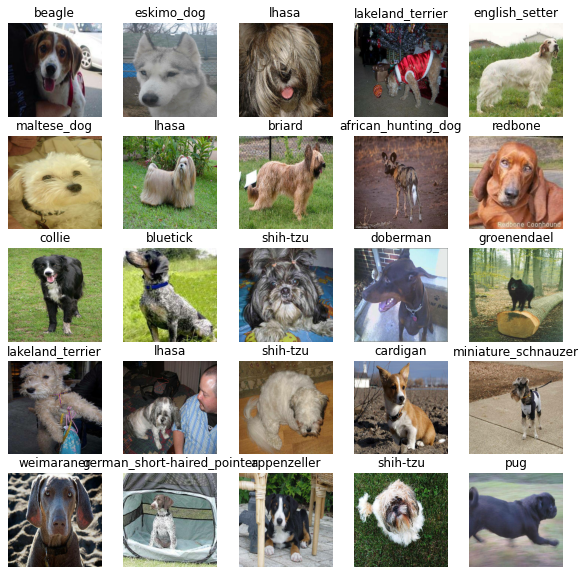

In [17]:
# Visualize training images from the training data batch
train_images, train_labels = next(train_data.as_numpy_iterator())
show_25_images(train_images, train_labels)

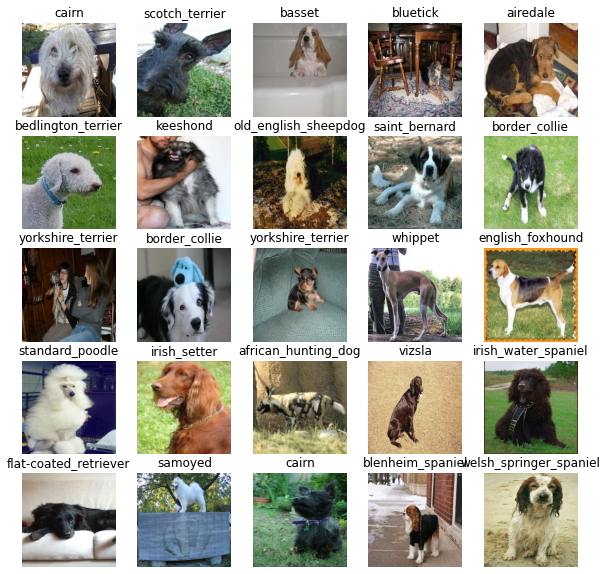

In [18]:
# Visualize validation images from the validation data batch
val_images, val_labels = next(val_data.as_numpy_iterator())
show_25_images(val_images, val_labels)

#### Creating and training a model
The data is ready, let's prepare it modelling. We'll use an existing model from [TensorFlow Hub.](https://tfhub.dev/)

TensorFlow Hub is a resource where you can find pretrained machine learning models for the problem you're working on.

Using a pretrained machine learning model is often referred to as **transfer learning**.

*Why use a pretrained model?*
Building a machine learning model and training it on lots from scratch can be expensive and time consuming.

Transfer learning helps alleviate some of these by taking what another model has learned and using that information with your own problem.

#### Building a model

- The input shape (images, in the form of Tensors) to our model.
- The output shape (image labels, in the form of Tensors) of our model.
- The URL of the model we want to use.

In [19]:
# Setup input shape to the model
INPUT_SHAPE = [None, IMG_SIZE, IMG_SIZE, 3] # batch, height, width, colour channels

# Setup output shape of the model
OUTPUT_SHAPE = len(unique_breeds) # number of unique labels

# Setup model URL from TensorFlow Hub
MODEL_URL = "https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/5"

In [20]:
# Create a function which builds a Keras model
def create_model(input_shape=INPUT_SHAPE, output_shape=OUTPUT_SHAPE, model_url=MODEL_URL):
    print("Building model with:", MODEL_URL)

    # Setup the model layers
    model = tf.keras.Sequential([
    hub.KerasLayer(MODEL_URL), # Layer 1 (input layer)
    tf.keras.layers.Dense(units=OUTPUT_SHAPE, 
                          activation="softmax") # Layer 2 (output layer)
    ])

    # Compile the model
    model.compile(
      loss=tf.keras.losses.CategoricalCrossentropy(), # Our model wants to reduce this (how wrong its guesses are)
      optimizer=tf.keras.optimizers.Adam(), # A friend telling our model how to improve its guesses
      metrics=["accuracy"] # We'd like this to go up
    )

    # Build the model
    model.build(INPUT_SHAPE) # Let the model know what kind of inputs it'll be getting

    return model

In [21]:
# Create a model and check its details
model = create_model()
model.summary()

Building model with: https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/5
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1001)              5432713   
_________________________________________________________________
dense (Dense)                (None, 120)               120240    
Total params: 5,552,953
Trainable params: 120,240
Non-trainable params: 5,432,713
_________________________________________________________________


#### Creating callbacks
Callbacks are helper functions a model can use during training to do things such as save a models progress, check a models progress or stop training early if a model stops improving.

`TensorBoard` helps provide a visual way to monitor the progress of your model during and after training.

To set up a TensorBoard callback and view TensorBoard in a notebook:

- Load the TensorBoard notebook extension.
- Create a TensorBoard callback which is able to save logs to a directory and pass it to our model's fit() function.
- Visualize the our models training logs using the %tensorboard magic function (we'll do this later on).

In [22]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

In [23]:
# Create a function to build a TensorBoard callback
def create_tensorboard_callback():
    # Create a log directory for storing TensorBoard logs
    logdir = os.path.join("data/logs",
                        # Make it so the logs get tracked whenever we run an experiment
                        datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
    return tf.keras.callbacks.TensorBoard(logdir)

In [24]:
# Create early stopping (once our model stops improving, stop training)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",
                                                  patience=3)

#### Training a model (on a subset of data)
This first model is only going to be trained on 1000 images. Or trained on 800 images and then validated on 200 images, meaning 1000 images total or about 10% of the total data.

We do this to make sure everything is working. And if it is, we can step it up later and train on the entire training dataset.

`NUM_EPOCHS` defines how many passes of the data we'd like our model to do.
A pass is equivalent to our model trying to find patterns in each dog image and see which patterns relate to each label.

10 could be a good start but so could 100. This is one of the reasons we created an early stopping callback. Having early stopping setup means if we set `NUM_EPOCHS` to 100 but our model stops improving after 22 epochs, it'll stop training.

In [25]:
# How many rounds should we get the model to look through the data?
NUM_EPOCHS = 100

In [26]:
# Build a function to train and return a trained model
def train_model():
    """
    Trains a given model and returns the trained version.
    """
    # Create a model
    model = create_model()

    # Create new TensorBoard session everytime we train a model
    tensorboard = create_tensorboard_callback()

    # Fit the model to the data passing it the callbacks we created
    model.fit(x=train_data,
            epochs=NUM_EPOCHS,
            validation_data=val_data,
            validation_freq=1, # check validation metrics every epoch
            callbacks=[tensorboard, early_stopping])

    return model

In [27]:
# Fit the model to the data
model = train_model()

Building model with: https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/5
Epoch 1/100
25/25 [==============================] - 5s 68ms/step - loss: 4.6773 - accuracy: 0.0950 - val_loss: 3.5925 - val_accuracy: 0.2400
Epoch 2/100
25/25 [==============================] - 1s 25ms/step - loss: 1.6894 - accuracy: 0.6825 - val_loss: 2.2904 - val_accuracy: 0.4500
Epoch 3/100
25/25 [==============================] - 1s 26ms/step - loss: 0.5881 - accuracy: 0.9225 - val_loss: 1.7960 - val_accuracy: 0.5450
Epoch 4/100
25/25 [==============================] - ETA: 0s - loss: 0.2580 - accuracy: 0.98 - 1s 25ms/step - loss: 0.2580 - accuracy: 0.9837 - val_loss: 1.6018 - val_accuracy: 0.5850
Epoch 5/100
25/25 [==============================] - 1s 25ms/step - loss: 0.1457 - accuracy: 0.9987 - val_loss: 1.5033 - val_accuracy: 0.6200
Epoch 6/100
25/25 [==============================] - 1s 27ms/step - loss: 0.0995 - accuracy: 1.0000 - val_loss: 1.4625 - val_accuracy: 0.6200
Epoch 7/100
2

### Checking the TensorBoard logs

In [28]:
%tensorboard --logdir data/logs

#### Making and evaluating predictions
Before we scale up and train on more data, let's see some other ways we can evaluate our model. Because although accuracy is a pretty good indicator of how our model is doing, it would be even better if we could see it in action.

Making predictions with a trained model is as calling `predict()` on it and passing it data in the same format the model was trained on.

Making predictions with our model returns an array with a different value for each label.

In this case, making predictions on the validation data (200 images) returns an array (predictions) of arrays, each containing 120 different values (one for each unique dog breed).

In [29]:
# Make predictions on the validation data (not used to train on)
predictions = model.predict(val_data, verbose=1) # verbose shows us how long there is to go
predictions

7/7 [==============================] - 0s 15ms/step


array([[2.34916341e-03, 1.20963436e-04, 2.19504489e-03, ...,
        5.66106290e-04, 2.13879248e-05, 3.15052550e-03],
       [3.68596433e-04, 4.17881500e-04, 7.97221530e-03, ...,
        1.67081202e-03, 9.93865542e-04, 1.62966408e-05],
       [3.45719673e-05, 2.84614449e-04, 5.76594357e-05, ...,
        6.93141075e-04, 3.99812561e-05, 1.37079987e-04],
       ...,
       [4.33673586e-06, 4.44947596e-04, 9.04385015e-05, ...,
        1.00645275e-05, 9.41214676e-05, 1.42571909e-04],
       [1.14177563e-03, 1.06639767e-04, 9.57789671e-05, ...,
        2.66754912e-04, 1.10519766e-04, 6.54318649e-03],
       [7.60849053e-03, 7.26022772e-05, 6.90803817e-03, ...,
        1.03537953e-02, 5.34105639e-04, 1.04583730e-03]], dtype=float32)

In [30]:
# Check the shape of predictions
predictions.shape

(200, 120)

In [31]:
# First prediction
print(predictions[0])
print(f"Max value (probability of prediction): {np.max(predictions[0])}") # the max probability value predicted by the model
print(f"Sum: {np.sum(predictions[0])}") # because we used softmax activation in our model, this will be close to 1
print(f"Max index: {np.argmax(predictions[0])}") # the index of where the max value in predictions[0] occurs
print(f"Predicted label: {unique_breeds[np.argmax(predictions[0])]}") # the predicted label

[2.34916341e-03 1.20963436e-04 2.19504489e-03 5.82638313e-04
 5.11168153e-04 4.60780175e-05 2.09592767e-02 6.25634566e-04
 8.90131705e-05 8.76476464e-04 1.92568009e-03 2.85452232e-04
 1.60373587e-04 1.53213696e-04 7.84419244e-05 2.93240475e-04
 6.39831269e-05 1.55837670e-01 1.29368527e-05 2.14334832e-05
 8.46809242e-04 1.48554696e-04 3.80471756e-05 1.77108007e-03
 7.07503568e-05 1.43209516e-04 3.15796614e-01 1.51592176e-04
 1.29285036e-03 1.03419392e-04 7.88097168e-05 1.64153799e-03
 5.46770927e-04 1.13551709e-04 1.59439907e-04 2.09109187e-02
 1.29270602e-05 2.31068159e-04 3.62278952e-04 1.48337960e-04
 2.66643416e-04 1.56487567e-05 9.81703924e-05 1.99490532e-05
 6.04300549e-05 3.73082148e-04 1.40960346e-05 5.79105690e-04
 4.41394106e-04 5.30934485e-04 3.93490191e-04 4.87372017e-05
 8.27905256e-04 1.40728196e-04 6.67294807e-05 3.31864139e-05
 2.37632077e-04 3.54401860e-03 4.88156278e-04 8.06741863e-02
 1.20383187e-03 2.61043388e-05 1.32112973e-03 1.54715555e-04
 1.17276060e-04 4.405147

In [32]:
# Turn prediction probabilities into their respective label (easier to understand)
def get_pred_label(prediction_probabilities):
    """
    Turns an array of prediction probabilities into a label.
    """
    return unique_breeds[np.argmax(prediction_probabilities)]

In [33]:
# Get a predicted label based on an array of prediction probabilities
pred_label = get_pred_label(predictions[0])
pred_label

'cairn'

In [34]:
# Create a function to unbatch a batched dataset
def unbatchify(data):
    """
    Takes a batched dataset of (image, label) Tensors and returns separate arrays
    of images and labels.
    """
    images = []
    labels = []
    # Loop through unbatched data
    for image, label in data.unbatch().as_numpy_iterator():
        images.append(image)
        labels.append(unique_breeds[np.argmax(label)])
    return images, labels

In [35]:
# Unbatchify the validation data
val_images, val_labels = unbatchify(val_data)
val_images[0], val_labels[0]

(array([[[0.29599646, 0.43284872, 0.3056691 ],
         [0.26635826, 0.32996926, 0.22846507],
         [0.31428418, 0.27701408, 0.22934894],
         ...,
         [0.77614343, 0.82320225, 0.8101595 ],
         [0.81291157, 0.8285351 , 0.8406944 ],
         [0.8209297 , 0.8263737 , 0.8423668 ]],
 
        [[0.2344871 , 0.31603682, 0.19543913],
         [0.3414841 , 0.36560842, 0.27241898],
         [0.45016077, 0.40117094, 0.33964607],
         ...,
         [0.7663987 , 0.8134138 , 0.81350833],
         [0.7304248 , 0.75012016, 0.76590735],
         [0.74518913, 0.76002574, 0.7830809 ]],
 
        [[0.30157745, 0.3082587 , 0.21018331],
         [0.2905954 , 0.27066195, 0.18401104],
         [0.4138316 , 0.36170745, 0.2964005 ],
         ...,
         [0.79871625, 0.8418535 , 0.8606443 ],
         [0.7957738 , 0.82859945, 0.8605655 ],
         [0.75181633, 0.77904975, 0.8155256 ]],
 
        ...,
 
        [[0.9746779 , 0.9878955 , 0.9342279 ],
         [0.99153054, 0.99772066, 0.94278

In [36]:
def plot_pred(prediction_probabilities, labels, images, n=1):
    """
    View the prediction, ground truth label and image for sample n.
    """
    pred_prob, true_label, image = prediction_probabilities[n], labels[n], images[n]

    # Get the pred label
    pred_label = get_pred_label(pred_prob)

    # Plot image & remove ticks
    plt.imshow(image)
    plt.xticks([])
    plt.yticks([])

    # Change the color of the title depending on if the prediction is right or wrong
    if pred_label == true_label:
        color = "green"
    else:
        color = "red"

    plt.title("{} {:2.0f}% ({})".format(pred_label,
                                        np.max(pred_prob)*100,
                                        true_label),
                                        color=color)

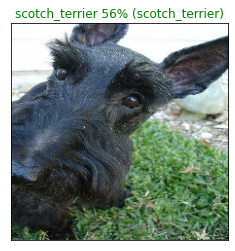

In [37]:
# View an example prediction, original image and truth label
plot_pred(prediction_probabilities=predictions,
          labels=val_labels,
          images=val_images)

In [38]:
def plot_pred_conf(prediction_probabilities, labels, n=1):
    """
    Plots the top 10 highest prediction confidences along with
    the truth label for sample n.
    """
    pred_prob, true_label = prediction_probabilities[n], labels[n]

    # Get the predicted label
    pred_label = get_pred_label(pred_prob)

    # Find the top 10 prediction confidence indexes
    top_10_pred_indexes = pred_prob.argsort()[-10:][::-1]
    # Find the top 10 prediction confidence values
    top_10_pred_values = pred_prob[top_10_pred_indexes]
    # Find the top 10 prediction labels
    top_10_pred_labels = unique_breeds[top_10_pred_indexes]

    # Setup plot
    top_plot = plt.bar(np.arange(len(top_10_pred_labels)), 
                       top_10_pred_values, 
                       color="grey")
    plt.xticks(np.arange(len(top_10_pred_labels)),
               labels=top_10_pred_labels,
               rotation="vertical")

    # Change color of true label
    if np.isin(true_label, top_10_pred_labels):
        top_plot[np.argmax(top_10_pred_labels == true_label)].set_color("green")
    else:
        pass

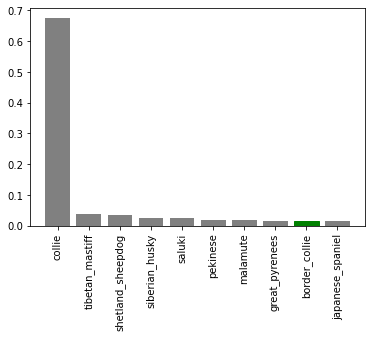

In [39]:
plot_pred_conf(prediction_probabilities=predictions,
               labels=val_labels, n=9)

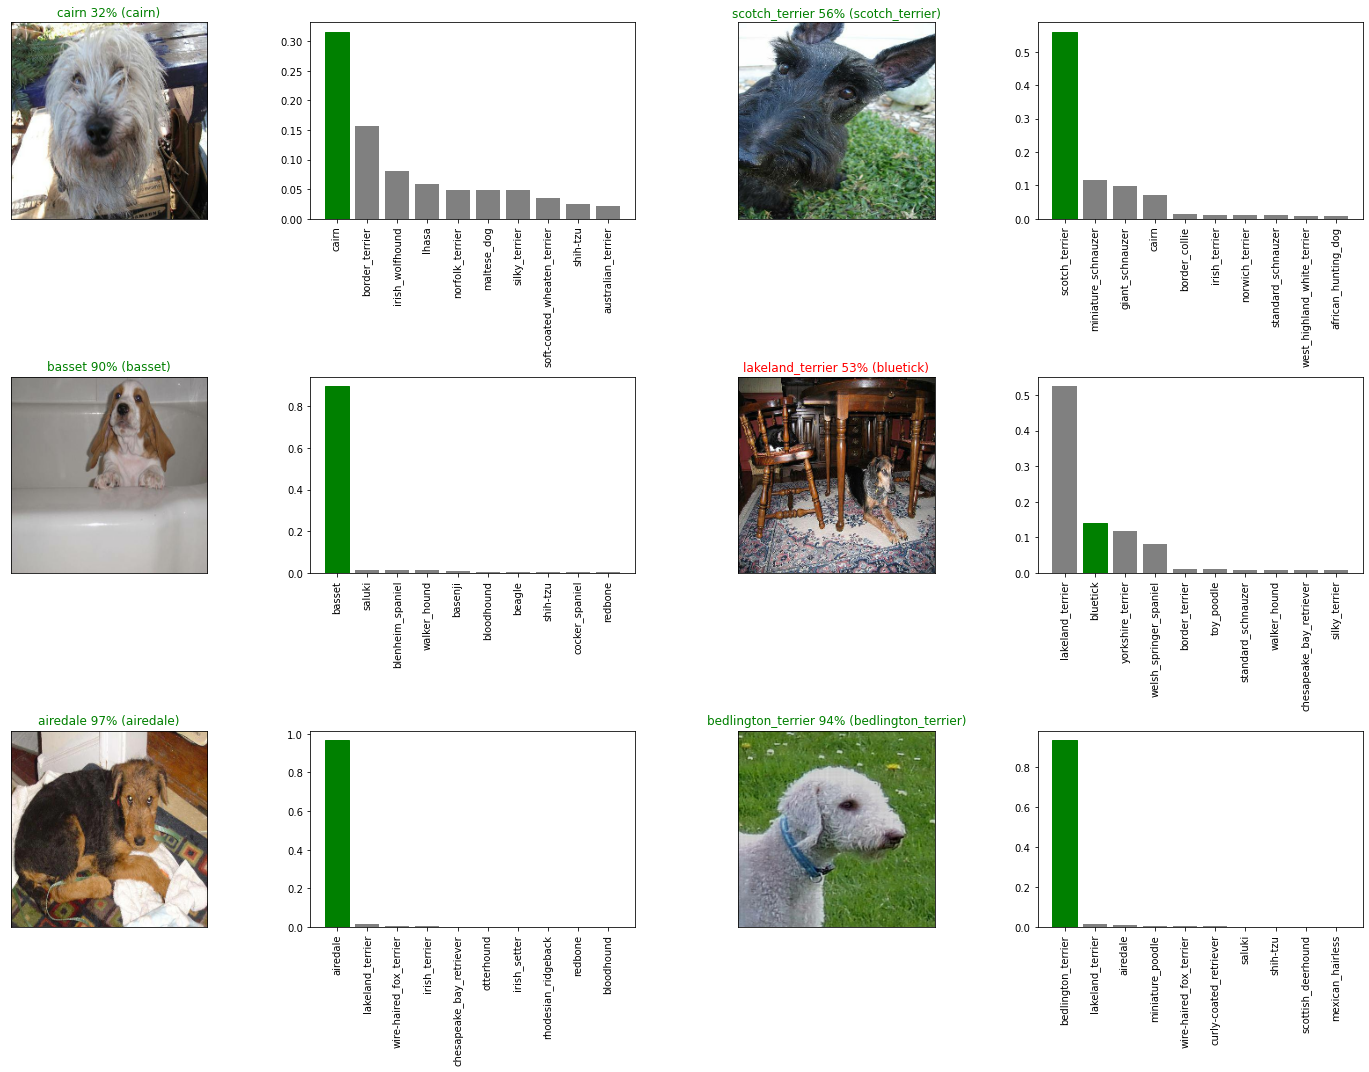

In [40]:
# Let's check a few predictions and their different values
i_multiplier = 0
num_rows = 3
num_cols = 2
num_images = num_rows*num_cols
plt.figure(figsize=(5*2*num_cols, 5*num_rows))
for i in range(num_images):
    plt.subplot(num_rows, 2*num_cols, 2*i+1)
    plot_pred(prediction_probabilities=predictions,
              labels=val_labels,
              images=val_images,
              n=i+i_multiplier)

    plt.subplot(num_rows, 2*num_cols, 2*i+2)
    plot_pred_conf(prediction_probabilities=predictions,
                   labels=val_labels,
                   n=i+i_multiplier)
    
plt.tight_layout(h_pad=1.0)
plt.show()

#### Saving and reloading a model
After training a model, it's a good idea to save it.
Saving it means you can share it with team, put it in an application and more importantly, won't have to go through the potentially expensive step of retraining it.

The format of an entire saved Keras model is `h5`.

In [41]:
def save_model(model, suffix=None):
    """
    Saves a given model in a models directory and appends a suffix (str)
    for clarity and reuse.
    """
    # Create model directory with current time
    modeldir = os.path.join("data/models",
                          datetime.datetime.now().strftime("%Y%m%d-%H%M%s"))
    model_path = modeldir + "-" + suffix + ".h5" # save format of model
    print(f"Saving model to: {model_path}...")
    model.save(model_path)
    return model_path

def load_model(model_path):
    """
    Loads a saved model from a specified path.
    """
    print(f"Loading saved model from: {model_path}")
    model = tf.keras.models.load_model(model_path,
                                     custom_objects={"KerasLayer":hub.KerasLayer})
    return model

In [42]:
# Save our model trained on 1000 images
save_model(model, suffix="1000-images-Adam")

Saving model to: data/models/20211209-11121639059155-1000-images-Adam.h5...


'data/models/20211209-11121639059155-1000-images-Adam.h5'

In [43]:
# Load our model trained on 1000 images
model_1000_images = load_model('data/models/20211209-11121639059155-1000-images-Adam.h5')

Loading saved model from: data/models/20211209-11121639059155-1000-images-Adam.h5


In [44]:
# Evaluate the pre-saved model
model.evaluate(val_data)

7/7 [==============================] - 0s 18ms/step - loss: 1.3525 - accuracy: 0.6350


[1.3524988889694214, 0.6349999904632568]

In [45]:
# Evaluate the loaded model
model_1000_images.evaluate(val_data)

7/7 [==============================] - 0s 18ms/step - loss: 1.3525 - accuracy: 0.6350


[1.3524988889694214, 0.6349999904632568]

#### Training a model (on the full data)
Now we know our model works on a subset of the data, we can start to move forward with training one on the full data.

Above, we saved all of the training filepaths to `X` and all of the training labels to `y`.

We've got over 10,000 images and labels in our training set.

Before train a model on these, we'll have to turn them into a data batch.

In [46]:
# Check the size of the full dataset
len(X), len(y)

(10222, 10222)

In [47]:
# Turn full training data in a data batch
full_data = create_data_batches(X, y)

Creating training data batches...


In [48]:
# Instantiate a new model for training on the full dataset
full_model = create_model()

Building model with: https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/5


In [49]:
# Create full model callbacks

# TensorBoard callback
full_model_tensorboard = create_tensorboard_callback()

# Early stopping callback
# Note: No validation set when training on all the data, therefore can't monitor validation accruacy
full_model_early_stopping = tf.keras.callbacks.EarlyStopping(monitor="accuracy",
                                                             patience=3)

In [50]:
%tensorboard --logdir data/logs

Reusing TensorBoard on port 6006 (pid 122839), started 0:01:11 ago. (Use '!kill 122839' to kill it.)

In [51]:
# Fit the full model to the full training data
full_model.fit(x=full_data,
               epochs=NUM_EPOCHS,
               callbacks=[full_model_tensorboard, 
                          full_model_early_stopping])

Epoch 1/100
320/320 [==============================] - 9s 22ms/step - loss: 1.3179 - accuracy: 0.6738
Epoch 2/100
320/320 [==============================] - 6s 19ms/step - loss: 0.3937 - accuracy: 0.8854
Epoch 3/100
320/320 [==============================] - 6s 19ms/step - loss: 0.2351 - accuracy: 0.9387
Epoch 4/100
320/320 [==============================] - 6s 19ms/step - loss: 0.1531 - accuracy: 0.9638
Epoch 5/100
320/320 [==============================] - 6s 19ms/step - loss: 0.1042 - accuracy: 0.9796
Epoch 6/100
320/320 [==============================] - 6s 19ms/step - loss: 0.0775 - accuracy: 0.9867
Epoch 7/100
320/320 [==============================] - 6s 19ms/step - loss: 0.0580 - accuracy: 0.9923
Epoch 8/100
320/320 [==============================] - 6s 19ms/step - loss: 0.0470 - accuracy: 0.9938
Epoch 9/100
320/320 [==============================] - 6s 19ms/step - loss: 0.0382 - accuracy: 0.9956
Epoch 10/100
320/320 [==============================] - 6s 19ms/step - loss: 0.031

In [52]:
# Save model to file
save_model(full_model, suffix="all-images-Adam")

Saving model to: data/models/20211209-11151639059357-all-images-Adam.h5...


'data/models/20211209-11151639059357-all-images-Adam.h5'

In [53]:
# Load in the full model
loaded_full_model = load_model('data/models/20211209-11151639059357-all-images-Adam.h5')

Loading saved model from: data/models/20211209-11151639059357-all-images-Adam.h5


#### Making predictions on the test dataset
Model has been trained on images in the form of Tensor batches, to make predictions on the test data, we'll have to get it into the same format.

To make `predictions` on the test data, we'll:

- Get the test image filenames.
- Convert the filenames into test data batches using `create_data_batches()`
    and setting the `test_data` parameter to True.
- Make a predictions array by passing the test data batches to the `predict()` function.

In [54]:
# Load test image filenames (since we're using os.listdir(), these already have .jpg)
test_path = "data/test/"
test_filenames = [test_path + fname for fname in os.listdir(test_path)]

test_filenames[:10]

['data/test/9ad3e517a87941d3bf1ddf48ad9341b3.jpg',
 'data/test/906dbdee434428bdd3e4fdd4c1e632ef.jpg',
 'data/test/c22459699dbe21aab3df8d14c8685b6e.jpg',
 'data/test/81d3092fff42afef68b123231c542e1f.jpg',
 'data/test/c8c5efff1a3c534b6eb8a3fc05c69033.jpg',
 'data/test/50f60661565a02c5b96f446f089832e6.jpg',
 'data/test/ac40a20790d53b782ee1484ff6e7d3f5.jpg',
 'data/test/fad571830be4ed3ec12514ac2d448375.jpg',
 'data/test/3232cf9ac52f412df2fda5614dd614e7.jpg',
 'data/test/2ee4109449b35f809ac82e2c5d78c230.jpg']

In [55]:
# How many test images are there?
len(test_filenames)

10357

In [56]:
# Create test data batch
test_data = create_data_batches(test_filenames, test_data=True)

Creating test data batches...


In [57]:
# Make predictions on test data batch using the loaded full model
test_predictions = loaded_full_model.predict(test_data,
                                             verbose=1)

324/324 [==============================] - 6s 16ms/step


#### Making predictions on custom images

The premise remains, if we want to make predictions on our own custom images, we have to pass them to the model in the same format the model was trained on.

To do so:

- Get the filepaths of our own images.
- Turn the filepaths into data batches using `create_data_batches()`.
  And since our custom images won't have labels, we set the `test_data` parameter to True.
- Pass the custom image data batch to our model's `predict()` method.
- Convert the prediction output probabilities to prediction labels.
- Compare the predicted labels to the custom images.

In [58]:
# Get custom image filepaths
custom_path = "data/dogs/"
custom_image_paths = [custom_path + fname for fname in os.listdir(custom_path)]

In [59]:
# Turn custom image into batch (set to test data because there are no labels)
custom_data = create_data_batches(custom_image_paths, test_data=True)

Creating test data batches...


In [60]:
# Make predictions on the custom data
custom_preds = loaded_full_model.predict(custom_data)

In [61]:
# Get custom image prediction labels
custom_pred_labels = [get_pred_label(custom_preds[i]) for i in range(len(custom_preds))]
custom_pred_labels

['chow']

In [62]:
# Get custom images (our unbatchify() function won't work since there aren't labels)
custom_images = []
# Loop through unbatched data
for image in custom_data.unbatch().as_numpy_iterator():
    custom_images.append(image)

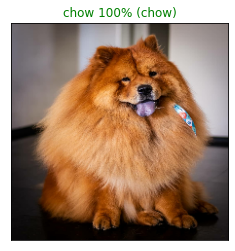

In [63]:
# Check custom image predictions
plot_pred(prediction_probabilities=custom_preds,
          labels=custom_pred_labels,
          images=custom_images, n=0)

**The model was able to classify my dog correctly.** =)